# VLNCE+EnvDrop AUG
VLNCE 202779

VLNCE + AUG 601038 

In [1]:
import gc
import os,sys
os.chdir("/root/MLA/")
import random
import warnings
from collections import defaultdict
from datetime import datetime

import lmdb
import h5py
import msgpack_numpy
import numpy as np
import torch
from tqdm.notebook import tqdm
from habitat import logger
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.common.environments import get_env_class
from habitat_baselines.common.obs_transformers import (
    apply_obs_transforms_batch,
    apply_obs_transforms_obs_space,
    get_active_obs_transforms,
)
from habitat_baselines.common.tensorboard_utils import TensorboardWriter
from habitat_baselines.utils.common import batch_obs

from vlnce_baselines.common.aux_losses import AuxLosses
from vlnce_baselines.common.base_il_trainer import BaseVLNCETrainer
from vlnce_baselines.common.env_utils import construct_envs
from vlnce_baselines.common.utils import extract_instruction_tokens
from vlnce_baselines.config.default import get_config
def _pause_envs(
    envs_to_pause,
    envs,
    not_done_masks,
    prev_actions,
    batch,
    rgb_frames=None,
):
    # pausing envs with no new episode
    if len(envs_to_pause) > 0:
        state_index = list(range(envs.num_envs))
        for idx in reversed(envs_to_pause):
            state_index.pop(idx)
            envs.pause_at(idx)

        # indexing along the batch dimensions
        not_done_masks = not_done_masks[state_index]
        prev_actions = prev_actions[state_index]

        for k, v in batch.items():
            batch[k] = v[state_index]

        if rgb_frames is not None:
            rgb_frames = [rgb_frames[i] for i in state_index]

    return (
        envs,
        not_done_masks,
        prev_actions,
        batch,
        rgb_frames,
    )

## VLN-CE train

In [ ]:
CONFIG = "/root/MLA/vlnce_baselines/config/transformer/transformer.yaml"

device = torch.device("cuda")
config = get_config(CONFIG)
envs = construct_envs(config, get_env_class(config.ENV_NAME))
expert_uuid = config.IL.DAGGER.expert_policy_sensor_uuid
prev_actions = torch.zeros(
    envs.num_envs,
    1,
    device=device,
    dtype=torch.long,
)
not_done_masks = torch.zeros(
    envs.num_envs, 1, dtype=torch.bool, device=device
)

observations = envs.reset()
observations = extract_instruction_tokens(
    observations, config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID
)
batch = batch_obs(observations, device)
obs_transforms = get_active_obs_transforms(config)
batch = apply_obs_transforms_batch(batch, obs_transforms)

episodes = [[] for _ in range(envs.num_envs)]
skips = [False for _ in range(envs.num_envs)]
# Populate dones with False initially
dones = [False for _ in range(envs.num_envs)]

collected_eps = 0
ep_ids_collected = None
ensure_unique_episodes = True
if ensure_unique_episodes:
    ep_ids_collected = {
        ep.episode_id for ep in envs.current_episodes()
    }

In [ ]:
RGB_SIZE = 224
DEPTH_SIZE = 256
SUB_LEN = 12
INST_LEN = 77
DOWNSAMPLE = 3
with tqdm(total=config.IL.DAGGER.update_size, dynamic_ncols=True) as pbar, h5py.File('/hy-tmp/stage3/data.mat','a') as t:
    if "rgb" in t:
        del t["rgb"]
    if "depth" in t:
        del t["depth"]
    target_rgb = t.create_dataset("rgb", shape=(0, RGB_SIZE, RGB_SIZE, 3), maxshape=(None, RGB_SIZE, RGB_SIZE, 3), dtype=np.uint8)
    target_depth = t.create_dataset("depth", shape=(0, DEPTH_SIZE, DEPTH_SIZE, 1), maxshape=(None, DEPTH_SIZE, DEPTH_SIZE, 1), dtype=float)
    if "instructions" in t:
        del t["instructions"]
    if "sub_instructions" in t:
        del t["sub_instructions"]
    target_inst = t.create_dataset("instructions", shape=(0, INST_LEN), maxshape=(None, INST_LEN), dtype=np.int32)
    target_sub = t.create_dataset("sub_instructions", shape=(0, SUB_LEN, INST_LEN), maxshape=(None, SUB_LEN, INST_LEN), dtype=np.int32)
    while collected_eps < config.IL.DAGGER.update_size:
        current_episodes = None
        envs_to_pause = None
        if ensure_unique_episodes:
            envs_to_pause = []
            current_episodes = envs.current_episodes()

        for i in range(envs.num_envs):
            if dones[i] and not skips[i]:
                ep = episodes[i]
                traj_obs = batch_obs(
                    [step[0] for step in ep],
                    device=torch.device("cpu"),
                )
                for k, v in traj_obs.items():
                    traj_obs[k] = v.numpy()
                    if config.IL.DAGGER.lmdb_fp16:
                        traj_obs[k] = traj_obs[k].astype(np.float16)

                rgbi = traj_obs["rgb"][::DOWNSAMPLE]
                depthi = traj_obs["depth"][::DOWNSAMPLE]
                insti = traj_obs["instruction"][::DOWNSAMPLE]
                subi = traj_obs["sub_instruction"][::DOWNSAMPLE]
                n = rgbi.shape[0]
                assert (depthi.shape[0]==n and insti.shape[0]==n and subi.shape[0]==n)
                target_rgb.resize(target_rgb.shape[0]+n, axis=0)
                target_rgb[-n:] = rgbi
                target_depth.resize(target_depth.shape[0]+n, axis=0)
                target_depth[-n:] = depthi
                target_inst.resize(target_inst.shape[0]+n, axis=0)
                target_inst[-n:] = insti
                target_sub.resize(target_sub.shape[0]+n, axis=0)
                target_sub[-n:] = subi

                pbar.update()
                collected_eps += 1

                if ensure_unique_episodes:
                    if (
                        current_episodes[i].episode_id
                        in ep_ids_collected
                    ):
                        envs_to_pause.append(i)
                    else:
                        ep_ids_collected.add(
                            current_episodes[i].episode_id
                        )
            if dones[i]:
                episodes[i] = []

        if ensure_unique_episodes:
            (
                envs,
                not_done_masks,
                prev_actions,
                batch,
                _,
            ) = _pause_envs(
                envs_to_pause,
                envs,
                not_done_masks,
                prev_actions,
                batch,
            )
            if envs.num_envs == 0:
                break

        actions = batch[expert_uuid].long()

        for i in range(envs.num_envs):
            episodes[i].append(
                (
                    observations[i],
                    prev_actions[i].item(),
                    batch[expert_uuid][i].item(),
                )
            )

        skips = batch[expert_uuid].long() == -1
        actions = torch.where(
            skips, torch.zeros_like(actions), actions
        )
        skips = skips.squeeze(-1)  # .to(device="cpu")
        prev_actions.copy_(actions)

        outputs = envs.step([a[0].item() for a in actions])
        observations, _, dones, _ = [list(x) for x in zip(*outputs)]

        observations = extract_instruction_tokens(
            observations,
            config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID,
        )
        batch = batch_obs(observations, device)
        batch = apply_obs_transforms_batch(batch, obs_transforms)

        not_done_masks = torch.tensor(
            [[0] if done else [1] for done in dones],
            dtype=torch.uint8,
            device=device,
        )


envs.close()
envs = None


  0%|                                                                                                         …

(202779, 224, 224, 3)


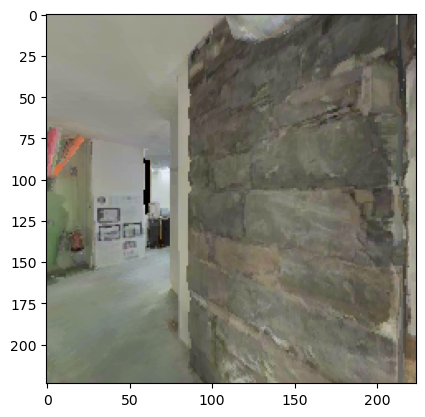

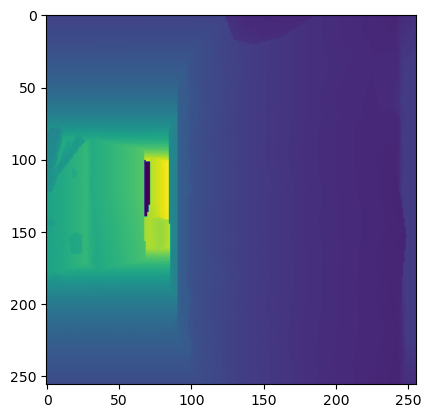

In [5]:
import matplotlib.pyplot as plt
with h5py.File('/hy-tmp/stage3/data.mat','r') as t:
    print(t["rgb"].shape)
    plt.figure()
    plt.imshow(t["rgb"][10000])
    plt.figure()
    plt.imshow(t["depth"][10000])
    # print(t["instructions"][10000])
    # print(t["sub_instructions"][10000])

In [40]:
import gzip
import json
with gzip.open("/root/MLA/data/datasets/R2R_VLNCE_NRSub_T/train/train_gt.json.gz", "r") as f:
    data = json.loads(f.read())

In [41]:
lens = []
for k,v in data.items():
    lens.append(v["forward_steps"])

In [42]:
import numpy as np
print(np.mean(lens))

37.73860800443664


In [6]:
30.0*10819

324570.0

In [38]:
len(data)

157232

In [20]:
157232 * 3

471696

2023-02-04 08:46:04,622 Worker KeyboardInterrupt
I0204 08:46:04.623366 3872519 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I0204 08:46:04.623453 3872519 SemanticScene.h:43] Deconstructing SemanticScene
2023-02-04 08:46:04,623 Worker KeyboardInterrupt
I0204 08:46:04.623711 3872520 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I0204 08:46:04.623823 3872520 SemanticScene.h:43] Deconstructing SemanticScene


## AUG

In [ ]:
CONFIG = "/root/MLA/vlnce_baselines/config/transformer/transformer_aug.yaml"

device = torch.device("cuda")
config = get_config(CONFIG)
envs = construct_envs(config, get_env_class(config.ENV_NAME))
expert_uuid = config.IL.DAGGER.expert_policy_sensor_uuid
prev_actions = torch.zeros(
    envs.num_envs,
    1,
    device=device,
    dtype=torch.long,
)
not_done_masks = torch.zeros(
    envs.num_envs, 1, dtype=torch.bool, device=device
)

observations = envs.reset()
observations = extract_instruction_tokens(
    observations, config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID
)
batch = batch_obs(observations, device)
obs_transforms = get_active_obs_transforms(config)
batch = apply_obs_transforms_batch(batch, obs_transforms)

episodes = [[] for _ in range(envs.num_envs)]
skips = [False for _ in range(envs.num_envs)]
# Populate dones with False initially
dones = [False for _ in range(envs.num_envs)]

collected_eps = 0
ep_ids_collected = None
ensure_unique_episodes = True
if ensure_unique_episodes:
    ep_ids_collected = {
        ep.episode_id for ep in envs.current_episodes()
    }

In [ ]:
RGB_SIZE = 224
DEPTH_SIZE = 256
SUB_LEN = 12
INST_LEN = 77
DOWNSAMPLE = 10
with tqdm(total=config.IL.DAGGER.update_size, dynamic_ncols=True) as pbar, h5py.File('/hy-tmp/stage3/data.mat','a') as t:
    target_rgb = t["rgb"]
    target_depth = t["depth"]
    target_inst = t["instructions"]
    target_sub = t["sub_instructions"]
    while collected_eps < config.IL.DAGGER.update_size and target_rgb.shape[0]<601034:
        current_episodes = None
        envs_to_pause = None
        if ensure_unique_episodes:
            envs_to_pause = []
            current_episodes = envs.current_episodes()

        for i in range(envs.num_envs):
            if dones[i] and not skips[i]:
                ep = episodes[i]
                traj_obs = batch_obs(
                    [step[0] for step in ep],
                    device=torch.device("cpu"),
                )
                for k, v in traj_obs.items():
                    traj_obs[k] = v.numpy()
                    if config.IL.DAGGER.lmdb_fp16:
                        traj_obs[k] = traj_obs[k].astype(np.float16)

                rgbi = traj_obs["rgb"][::DOWNSAMPLE]
                depthi = traj_obs["depth"][::DOWNSAMPLE]
                insti = traj_obs["instruction"][::DOWNSAMPLE]
                subi = traj_obs["sub_instruction"][::DOWNSAMPLE]
                n = rgbi.shape[0]
                assert (depthi.shape[0]==n and insti.shape[0]==n and subi.shape[0]==n)
                target_rgb.resize(target_rgb.shape[0]+n, axis=0)
                target_rgb[-n:] = rgbi
                target_depth.resize(target_depth.shape[0]+n, axis=0)
                target_depth[-n:] = depthi
                target_inst.resize(target_inst.shape[0]+n, axis=0)
                target_inst[-n:] = insti
                target_sub.resize(target_sub.shape[0]+n, axis=0)
                target_sub[-n:] = subi

                pbar.update()
                collected_eps += 1

                if ensure_unique_episodes:
                    if (
                        current_episodes[i].episode_id
                        in ep_ids_collected
                    ):
                        envs_to_pause.append(i)
                    else:
                        ep_ids_collected.add(
                            current_episodes[i].episode_id
                        )
            if dones[i]:
                episodes[i] = []

        if ensure_unique_episodes:
            (
                envs,
                not_done_masks,
                prev_actions,
                batch,
                _,
            ) = _pause_envs(
                envs_to_pause,
                envs,
                not_done_masks,
                prev_actions,
                batch,
            )
            if envs.num_envs == 0:
                break

        actions = batch[expert_uuid].long()

        for i in range(envs.num_envs):
            episodes[i].append(
                (
                    observations[i],
                    prev_actions[i].item(),
                    batch[expert_uuid][i].item(),
                )
            )

        skips = batch[expert_uuid].long() == -1
        actions = torch.where(
            skips, torch.zeros_like(actions), actions
        )
        skips = skips.squeeze(-1)  # .to(device="cpu")
        prev_actions.copy_(actions)

        outputs = envs.step([a[0].item() for a in actions])
        observations, _, dones, _ = [list(x) for x in zip(*outputs)]

        observations = extract_instruction_tokens(
            observations,
            config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID,
        )
        batch = batch_obs(observations, device)
        batch = apply_obs_transforms_batch(batch, obs_transforms)

        not_done_masks = torch.tensor(
            [[0] if done else [1] for done in dones],
            dtype=torch.uint8,
            device=device,
        )


envs.close()
envs = None


In [14]:
import gzip
import json
with gzip.open("/root/MLA/data/datasets/R2R_VLNCE_NRSub_T/train/train_sub.json.gz", "r") as f:
    data = json.loads(f.read())

In [17]:
import gzip
import json
with gzip.open("/root/MLA/data/datasets/R2R_VLNCE_NRSub_T/joint_train_envdrop/joint_train_envdrop_sub.json.gz", "r") as f:
    aug_data = json.loads(f.read())

In [4]:
with h5py.File('/hy-tmp/stage3/data.mat','r') as t:
    print(t["rgb"].shape)

(601038, 224, 224, 3)
